# Part 1: DIY Diffusion

In this assignment, you will define and pretrain an unconditional diffusion model from scratch for generating (simple, low-resolution) images of Pokemon sprites.

## Learning Objectives
You will:
1. Implement the forward diffusion process for noising an image
2. Utilize a predefined UNet architecture for the reverse diffusion process
3. Implement the training procedure for modeling the reverse diffusion process with a UNet architecture
4. Conduct pre-training of a diffusion-based image generation model on a large dataset of images
5. Implement the inference/sampling procedure for a diffusion-based generative image model
6. Evaluate the trained model qualitatively and quantitatively for realism and diversity of generations

Note: This assignment is intended to utilize GPU resources such as `CUDA` through the CS department cluster, Google colab (or local GPU resources for those running on machines with GPU support). The **code below assumes CUDA**.

First we check for a GPU and download the data. The code creates a PyTorch `Dataset` and batched `Dataloader` for serving the images.

The **`show_image_tensor`** helper function defined below takes the tensor of an image as represented in the `Dataloader` and as we will use for the Diffusion process and makes the necessary transformations to visualize it to the screen. We will call this `show_image_tensor` function several times to visualize results throughout this assignment -- it is provided so you can focus on the machine learning logic instead of the scaling for graphics and rendering.

For simplicity and ease of training in a limited time on limited hardware, the assignment recommends using the `pikachus` dataset consisting of 24 images of Pikachus only. This allows for training a generative model (overfit to the data and only capable of generating similar looking Pikachus) from scratch in a matter of minutes on a GPU. Optionally, the `pokemon_simple` dataset consisting of 1,025 images of diverse Pokemon is also provided -- note that training on this larger and more diverse dataset can lead to more interesting generations but may require tens of minutes or hours of training.

Dataset already exists: 24 images
Dataset loaded: 24 images
Batch size: 4
Total batches: 6


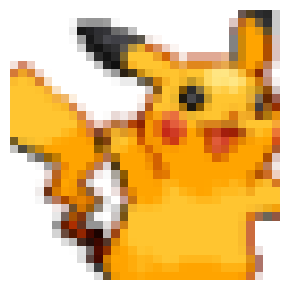

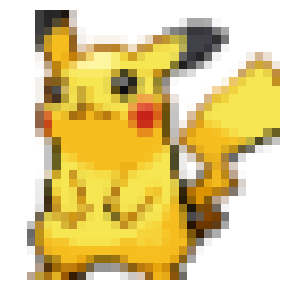

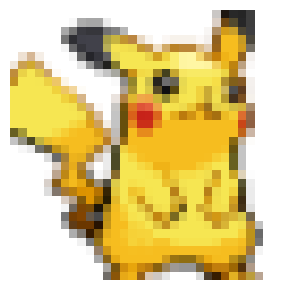

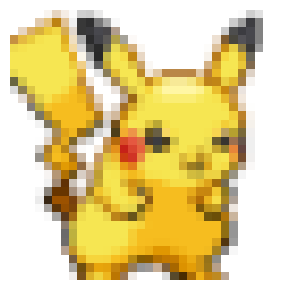

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import zipfile

# Recommended to use the pikachus dataset for easier training
# contains only 24 example images of Pikachu, model only needs
# to learn to generate Pikachu with minimal diversity.
# Can be trained in minutes on a GPU
DATASET_URL = "https://duke.box.com/shared/static/63erlp2yryypscx7g54u1691bo3c0u4m.zip"
DATASET_DIR = "pikachus"

# Optionally, can use the pokemon_simple dataset containing 1,025 images of different
# pokemon. Doable but not recommended if computational resources and training time are
# a concern, may take tens of minutes or hours to train on GPU.
#DATASET_URL = "https://duke.box.com/shared/static/pvosp7eyjhcr7d0hd0hx3cm3qq0c6h7a.zip"
#DATASET_DIR = "pokemon_simple"

# Check if already downloaded
if Path(DATASET_DIR).exists() and len(list(Path(DATASET_DIR).glob('*.png'))) > 1:
    print(f"Dataset already exists: {len(list(Path(DATASET_DIR).glob('*.png')))} images")
else:
    print("Downloading Pokemon sprites dataset...")
    urllib.request.urlretrieve(DATASET_URL, "dataset.zip")

    print("Extracting...")
    with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
        zip_ref.extractall('.')

    # Cleanup
    Path("dataset.zip").unlink()


def center_crop_pokemon(image, crop_size):
    """Center crop to focus on Pokemon instead of background."""
    width, height = image.size
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size
    return image.crop((left, top, right, bottom))

transform = transforms.Compose([
    transforms.Lambda(lambda img: center_crop_pokemon(img, crop_size=40)),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class PokemonDataset(Dataset):
    """
    Dataset of Pokemon sprites.
    Each image is cropped to 40x40, then resized to 32x32 RGB, normalized to [-1, 1].
    """

    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.image_files = sorted(list(self.data_dir.glob("*.png")))
        self.transform = transform

        if len(self.image_files) == 0:
            raise ValueError(f"No images found in {data_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

dataset = PokemonDataset(data_dir=DATASET_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Dataset loaded: {len(dataset)} images")
print(f"Batch size: {dataloader.batch_size}")
print(f"Total batches: {len(dataloader)}")


def show_image_tensor(tensor, ax=None, title=None):
    """
    Helper function to display a single image tensor.

    Args:
        tensor: Image tensor (C, H, W) normalized to [-1, 1]
        ax: Matplotlib axis (creates new figure if None)
        title: Optional title for the image
    """
    img_np = ((tensor + 1) / 2).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

    if ax is None:
        plt.figure(figsize=(3, 3))
        plt.imshow(img_np)
        plt.axis('off')
        if title:
            plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        ax.imshow(img_np)
        ax.axis('off')
        if title:
            ax.set_title(title)

# Visualize training batch
batch = next(iter(dataloader))
for img in batch:
    show_image_tensor(img)

**NOTE about resolution** The code above crops and reshapes the images to be 32x32 pixel color images, where a batch of such images is a tensor of shape `[batch_size, 3, 32, 32]`.

Next we define a helper function **`prepare_noise_schedule`** that takes a starting and ending beta value (per-step noise scale) and the number of timesteps in the Diffusion process, and returns a beta_t value for every step  along with an alpha value for every step (cumulative noise up to that step).

While you can experiment with different values if you like, we recommend the default settings of the `prepare_noise_schedule` for your training.

In [2]:
def prepare_noise_schedule(device, timesteps=200, beta_start=0.0001, beta_end=0.02):
    """
    Precompute all values needed for the forward diffusion process.

    Args:
        timesteps: Total number of diffusion steps
        beta_start: Starting noise level
        beta_end: Ending noise level

    Returns (betas, alphas):
        - betas: Noise schedule
        - alphas: Cumulative product of (1 - betas)
    """
    betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
    alphas = torch.cumprod(1.0 - betas, dim=0)

    return betas, alphas

## Task 1

In diffusion models, the **forward process** gradually adds noise to an image over `T` timesteps until it becomes pure Gaussian noise. This process follows the equation:

$$x_t = \sqrt{\alpha_t} \cdot x_0 + \sqrt{(1 - \alpha_t)} \cdot \epsilon$$

where x_0 is the original image, x_t is the noised image at timestep t, α_t is the cumulative noise schedule, and ε is Gaussian noise.

**TODOS:** Implement the `forward_diffusion()` function that takes an image and applies the forward diffusion process for all timesteps. Should return a list of progressively noisier versions of the input image.

**Implementation Details:**
1. Call `prepare_noise_schedule()` to get the beta and alpha schedules
2. For each timestep t from 0 to T-1:
   - Sample random Gaussian noise with the same shape as the input image
   - Compute the noised image using the equation above
   - Add the noised image to your list
3. Return the list of noised images

**Helpful documentation:**
- [`torch.randn_like()`](https://pytorch.org/docs/stable/generated/torch.randn_like.html) - Generate random noise matching image dimensions
- [`torch.sqrt()`](https://pytorch.org/docs/stable/generated/torch.sqrt.html) - Compute square roots (or use `math.sqrt()` for scalar values)

**Test Your Implementation and Expected Results.** You can run the following code cell to visualize your forward diffusion implementation. You should see a gradual progression from the original image to pure noise. Early timesteps should be barely noisy, middle timesteps should show a mix of structure and noise, and final timesteps should appear as completely random noise.

In [3]:
from math import sqrt

def forward_diffusion(image, device, timesteps):
    """
    Apply forward diffusion process to gradually add noise to an image.

    Args:
        image: Input image tensor (C, H, W)
        device: torch device
        timesteps: Number of diffusion steps

    Returns:
        noised_images: List of progressively noised images, one per timestep
    """
    # TODO: Implement forward_diffusion
    beta_schedules, alpha_schedules = prepare_noise_schedule(device, timesteps)
    noised_images = []
    x_O = image.to(device)
    for t in range(timesteps):
      gaussian_noise = torch.randn_like(x_O)
      a_t = alpha_schedules[t]
      x_t = torch.sqrt(a_t) * x_O + torch.sqrt(1 - a_t) * gaussian_noise
      noised_images.append(x_t)
    return noised_images

Using device: cuda
Showing timesteps: [0, 50, 100, 150, 199]


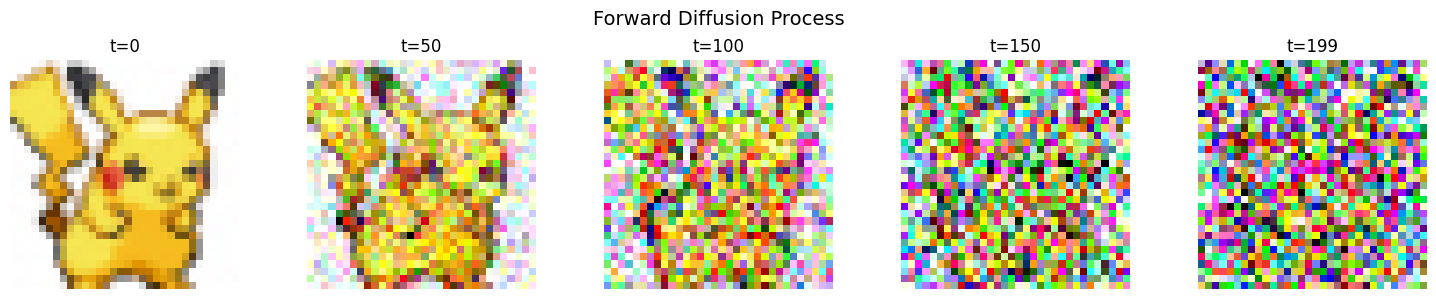

In [4]:
# Initialize noise schedule

# We recommend using T=200 throughout this assignment
# for the number of steps to the diffusion process
T = 200

# Check for GPU
device = torch.device("cuda")
print(f"Using device: {device}")

# Get sample image and apply forward diffusion
sample_image = dataset[0]
noised_images = forward_diffusion(sample_image, device, T)

timesteps_to_show = [0, T//4, T//2, (3*T)//4, T-1]
print(f"Showing timesteps: {timesteps_to_show}")
fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))
for idx, t in enumerate(timesteps_to_show):
    show_image_tensor(noised_images[t], ax=axes[idx], title=f"t={t}")
plt.suptitle("Forward Diffusion Process", fontsize=14)
plt.tight_layout()
plt.show()

## Task 2

The UNet architecture serves as our model for the reverse diffusion process (the prediction of noise that is used for generation). It takes a noised image and a timestep as input, and predicts the noise that was added to create that noised image.

The UNet is already implemented for you below -- we are focusing primarily on the diffusion process modeling for this part rather than the model architecture. Nonetheless, you should review and familiarize yourself with the key components of the architecture as defined. Then **answer the reflection questions that follow.**

The key components of the model include:

1. **Time Embedding**: Converts the timestep `t` into a learned representation using sinusoidal positional encoding
2. **Encoder (Downsampling)**: Extracts hierarchical features while reducing spatial dimensions
3. **Bottleneck**: Processes features at the lowest resolution
4. **Decoder (Upsampling)**: Reconstructs the output using skip connections from the encoder
5. **Residual Blocks**: Each block incorporates the time embedding to make the network time-aware



In [5]:
import torch.nn.functional as F
from tqdm import tqdm

class ResidualBlock(nn.Module):
    """Residual block with time embedding."""

    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = F.relu(self.conv1(x))
        time_emb = F.relu(self.time_mlp(t))
        h = h + time_emb[:, :, None, None]  # Broadcast to (B, C, H, W)
        h = F.relu(self.conv2(h))
        return h + self.shortcut(x)


class SinusoidalPositionEmbedding(nn.Module):
    """Timestep embedding using sinusoidal functions."""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class SimpleUNet(nn.Module):
    def __init__(self, channels=[64, 128, 256, 512], time_emb_dim=128):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial conv
        self.conv_in = nn.Conv2d(3, channels[0], 3, padding=1)

        # Encoder (downsampling)
        self.down1 = ResidualBlock(channels[0], channels[1], time_emb_dim)
        self.down2 = ResidualBlock(channels[1], channels[2], time_emb_dim)
        self.down3 = ResidualBlock(channels[2], channels[3], time_emb_dim)

        # Bottleneck
        self.bottleneck = ResidualBlock(channels[3], channels[3], time_emb_dim)

        # Decoder (upsampling)
        self.up3 = ResidualBlock(channels[3] + channels[2], channels[2], time_emb_dim)
        self.up2 = ResidualBlock(channels[2] + channels[1], channels[1], time_emb_dim)
        self.up1 = ResidualBlock(channels[1] + channels[0], channels[0], time_emb_dim)

        # Output
        self.conv_out = nn.Conv2d(channels[0], 3, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x0 = self.conv_in(x)

        # Encoder
        x1 = self.down1(F.max_pool2d(x0, 2), t_emb)
        x2 = self.down2(F.max_pool2d(x1, 2), t_emb)
        x3 = self.down3(F.max_pool2d(x2, 2), t_emb)

        # Bottleneck
        x = self.bottleneck(x3, t_emb)

        # Decoder with skip connections
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.up3(torch.cat([x, x2], dim=1), t_emb)

        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.up2(torch.cat([x, x1], dim=1), t_emb)

        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.up1(torch.cat([x, x0], dim=1), t_emb)

        # Output
        return self.conv_out(x)

model = SimpleUNet().to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {num_params:,} parameters")

# Test forward pass
test_input = torch.randn(2, 3, 32, 32).to(device)
test_t = torch.randint(0, T, (2,)).to(device)
test_output = model(test_input, test_t)
print(f"Test input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")

Model created with 13,154,627 parameters
Test input shape: torch.Size([2, 3, 32, 32])
Test output shape: torch.Size([2, 3, 32, 32])


**TODO: Answer the following reflection questions about the UNet architecture:**

1. **Skip connections:** Carefully consider the skip connections as implemented in the concatenations (`torch.cat`) within the `forward` method of the `SimpleUNet` class. At each decoder upsampling step, what is being concatenated with the current hidden representation? What purpose does this concatenation serve? Briefly answer both questions in 2-5 sentences.

With the UNet model, I notice that skip connections combines the encoder's feature maps with the decoder's representations. So the decoder's output would be concatenated with the encoder's output from the same resolution level at each upsampling step such as x2 with its matching upsampled feature map as an example here. With skip connections, it does help the model to keep important spatial details and structual information that could have been lost during downsampling. This does help the decoder to reconstruct images much more accurately with reduced noise to produce cleaner results.


2. **Time embeddings:** Observe that numerical vector embedding of the timestep within the diffusion process is used throughout forward propagation in the model. Considering the application and training of the UNet, why is it important to provide a timestep as an input to the model? Briefly answer in 2-5 sentences.

So with time embeddings, it does tell the model how much noise has been added to the image at each step. This information is important as it helps the UNet model understands what stage of the denoising process we are operating on. With different timesteps it would have different denoising strategies and behavior. Like for example, the model would focus more on cleaning up major distortions of the image when there are higher noise levels, however the model would focus more on recovering or refining small details in the image when there are lower noise levels. So this information ultimately helps the model to make better predicitions and would produce cleaner images throughout this denoising process.

3. **Input/output shape:** Considering the application and training of the UNet, why is it important that the input and output of the model have the same shape? Briefly answer in 2-5 sentences.

So looking at the results of the input shape and the output shape, I can see that the UNet takes in a noisy image with the shape of [batch size, channels, height, and width] and would output a noise prediction with the same shape as the input. It is important to keep the input and output of the model to have the same size since this would allow the model to properly subtract the predicted noise from the noisy image to make the image cleaner.Pretty much with the UNet, the encoder would compress the image to learn key features and then the decoder would restore the image to its original size to align with the input.

## Task 3:

Now we consider the reverse diffusion process, the generative process. Starting from pure noise, we iteratively denoise to generate a new image. At each step, the model predicts what noise was added, then we remove it (with a small amount of randomness to maintain diversity).

The reverse diffusion follows this procedure:
1. Start with pure Gaussian noise x_T
2. For each timestep from T-1 down to 0:
   - Use the model to predict the noise in x_t
   - Estimate the original image x_0 from the noisy image and predicted noise
   - If not at the final step, add a controlled amount of noise back (to account for the variance at timestep t-1)
   - Otherwise, return the denoised image

**Implement the `sample_image()` function** that generates a new image by reverse diffusion.

Details:
1. Start with random noise: `x = torch.randn(3, 32, 32)`
2. Loop backwards from timestep T-1 to 0:
   - **Add batch dimension** for model input: `x_batch = x.unsqueeze(0)` and `t_batch = torch.tensor([t], device=device)`
     - Note: The model expects batched inputs even for single images. The time embedding layer requires `t` to have shape `(batch_size,)` not just a scalar
   - Predict noise using the model
   - **Remove the batch dimension** from output: `noise_pred = noise_pred.squeeze(0)`
   - Compute the mean estimate for the original image: `pred_x0 = (x - sqrt(1-α_t) * noise_pred) / sqrt(α_t)`
   - Clamp pred_x0 to [-1, 1] to maintain valid image range and prevent numerical instability
   - If not the final step:
     - Compute x for previous timestep by adding noise to pred_x0 (accounting for the variance introduced by the forward diffusion process) scaled by sqrt(α_{t-1}).
   - Otherwise:
     - Set x = pred_x0 (final denoised image)
3. Return the generated image

**Helpful documentation:**
- [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html) - Create random noise tensor
- [`tensor.unsqueeze(0)`](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html) - Add batch dimension at position 0
- [`tensor.squeeze(0)`](https://pytorch.org/docs/stable/generated/torch.squeeze.html) - Remove batch dimension at position 0
- [`torch.clamp()`](https://pytorch.org/docs/stable/generated/torch.clamp.html) - Constrain values to a range
- [`@torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) - Disable gradient computation for inference

**Testing your Implementation and Expected Results:**  
Before training your own model, test your sampling implementation with a small pre-trained model. You can do this by running the following code cell, which downloads a pretrained Pikachu image generation model (using the same UNet architecture above) and tries to run your `sample_image` implementation. If everything is working correctly, you should see an image of a Pikachu generated that looks similar to those in the training data.

In [6]:
@torch.no_grad()
def sample_image(model, alphas, device):
    """
    Generate one image through reverse diffusion.

    Args:
        model: Trained UNet model
        alphas: Cumulative noise schedule from prepare_noise_schedule
        device: torch device

    Returns:
        x: Generated image tensor (3, 32, 32) normalized to [-1, 1]
    """

    # TODO: Implement reverse diffusion sampling
    x = torch.randn(3, 32, 32, device = device)
    for t in range(len(alphas) - 1, -1, -1):
      x_batch = x.unsqueeze(0)
      t_batch = torch.tensor([t], device = device)
      noise_pred = model(x_batch, t_batch).squeeze(0)
      pred_x0 = torch.clamp((x - torch.sqrt(1 - alphas[t]) * noise_pred) / torch.sqrt(alphas[t]), -1, 1)
      if t > 0:
        x = torch.sqrt(alphas[t - 1]) * pred_x0 + torch.sqrt(1 - alphas[t - 1]) * torch.randn_like(x)
      else:
        x = pred_x0
    return x

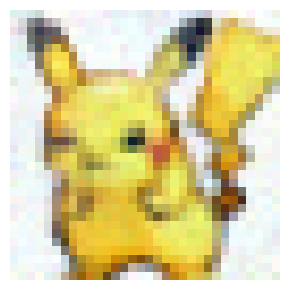

In [7]:
# Run to test your sample_image
# implementation qualitatively

import urllib.request
urllib.request.urlretrieve(
    "https://duke.box.com/shared/static/ss5rumoodo4wz0dxm7vg6qj1okrekcwy.pth",
    "pretrained_pikachu_model.pth"
)
pretrained_model = SimpleUNet().to(device)
pretrained_model.load_state_dict(torch.load("pretrained_pikachu_model.pth"))

_, alphas = prepare_noise_schedule(device)
sample_img = sample_image(pretrained_model, alphas, device)
show_image_tensor(sample_img)

## Task 4

Now it's time to train your own DIY diffusion model for unconditional generation. Conceptually, the training process follows the steps:
1. Sample a random batch of training images and random timesteps for each
2. Add noise to the images according to the forward diffusion process for that timestep
3. Predict the added noise using the UNet model
4. Compute loss (MSE between predicted and actual noise)
5. Update model weights using backpropagation and a gradient descent step

Your task is to **Implement the training loop in the `train()` function** and then use it to train a model capable of generating images that qualitatively resemble the training data and achieve a low training loss.

**Implementation Details**
1. **Prepare inputs:**
   - Sample random timesteps: `t = torch.randint(0, T, (batch_size,), device=device)`
   - Generate random noise: `noise = torch.randn_like(batch)`
   
2. **Apply forward diffusion to create noisy images:**
   - Reshape alpha values for broadcasting: `sqrt_alphas_t = torch.sqrt(alphas[t]).view(-1, 1, 1, 1)`
   - Compute noised images: `x_t = sqrt_alphas_t * batch + sqrt_one_minus_alphas_t * noise`

3. **Get model prediction and compute loss:**
   - Predict noise: `predicted_noise = model(x_t, t)`
   - Compute MSE loss between predicted_noise and actual noise
   
4. **Update model:**
   - Zero gradients, backward pass, optimizer step

**Helpful documentation:**
- [`torch.randint()`](https://pytorch.org/docs/stable/generated/torch.randint.html) - Sample random integers
- [`F.mse_loss()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html) - Mean squared error loss
- [`optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) - Clear gradients

**Testing your Implementation and What to Expect:**
- **Loss:** Should steadily decrease from ~0.5-1.0 down to ~0.01-0.10 (for Pikachus) or ~0.05-0.15 (for diverse Pokemon)
- **Generated samples:** The model generates sample images every `gen_freq` epochs so you can monitor progress. These examples should gradually improve from random noise to vague shapes and color patches to recognizable Pokemon, qualitatively similar to the training example images.
- **Training time:** May take ~5-10 minutes for 500 epochs on the small Pikachus dataset with a GPU, which should suffice for training a model that generates recognizable Pokemon, qualitatively similar to the training example images

**Note on Overfitting.** For this part of the assignment, we are not considering statistical generalization or image generation **diversity** whatsoever. Instead, we are just focusing on an implementation of the diffusion process capable of generating **realistic** images like those in the training data. Training a model from scratch that can generate realistic and diverse images from a larger training dataset might require hours or days of training time.

For this pedagogical reason, we do not separate the data into train and test sets or implement any regularization strategies. For this assignment part you can just train for the recommended 500 epochs (or more if needed) and only need to consider the training loss and the quality of the generated images.

In [8]:
from math import ceil

def train(model, dataloader, num_epochs=500, lr=1e-4, gen_freq=50):
    """
    Train the diffusion model to predict noise.

    Args:
        model: SimpleUNet model
        dataloader: DataLoader with training images
        num_epochs: Total number of training epochs
        lr: Learning rate
        gen_freq: Generate sample image every N epochs

    Returns:
        losses: List of average loss per epoch
    """
    _, alphas = prepare_noise_schedule(device, timesteps=T)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    losses = []

    num_epoch_groups = ceil(num_epochs / gen_freq)
    print(f"\nGenerating example every {gen_freq} epochs.")
    print("="*70)

    for epoch_group in range(num_epoch_groups):
        pbar = tqdm(range(gen_freq), desc=f"Group {epoch_group+1}/{num_epoch_groups}")

        for epoch in pbar:
            total_loss = 0

            for batch in dataloader:
                batch = batch.to(device)

                # TODO: Implement training step on batch
                # and add loss to total_loss
                t = torch.randint(0, T, (batch.shape[0],), device = device)
                noise = torch.randn_like(batch)
                sqrt_alphas_t = torch.sqrt(alphas[t]).view(-1, 1, 1, 1)
                sqrt_one_minus_alphas_t = torch.sqrt(1 - alphas[t]).view(-1, 1, 1, 1)
                x_t = sqrt_alphas_t * batch + sqrt_one_minus_alphas_t * noise
                predicted_noise = model(x_t, t)
                MSE_loss = F.mse_loss(predicted_noise, noise)
                optimizer.zero_grad()
                MSE_loss.backward()
                optimizer.step()
                total_loss += MSE_loss.item()

            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            pbar.set_postfix({'loss': f'{avg_loss:.4f}'})

        # Generate and display sample image
        print(f"\nEpoch {(epoch_group+1)*gen_freq}: Loss = {avg_loss:.4f}")
        sample_img = sample_image(model, alphas, device)
        show_image_tensor(sample_img, title=f"Generated at epoch {(epoch_group+1)*gen_freq}")
        print()

    print("="*70)
    print("Training complete!")

    return losses


Generating example every 50 epochs.


Group 1/10: 100%|██████████| 50/50 [00:05<00:00,  9.17it/s, loss=0.1901]



Epoch 50: Loss = 0.1901


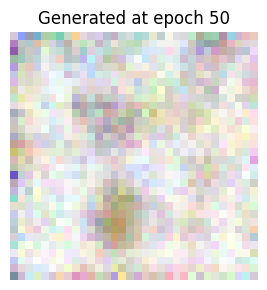

Group 2/10: 100%|██████████| 50/50 [00:05<00:00,  8.59it/s, loss=0.2700]



Epoch 100: Loss = 0.2700


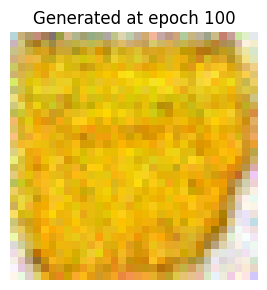

Group 3/10: 100%|██████████| 50/50 [00:05<00:00,  8.99it/s, loss=0.1379]



Epoch 150: Loss = 0.1379


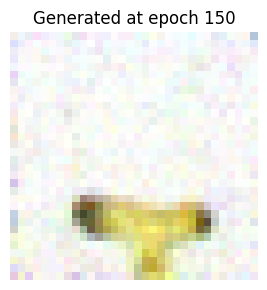

Group 4/10: 100%|██████████| 50/50 [00:05<00:00,  8.48it/s, loss=0.1435]



Epoch 200: Loss = 0.1435


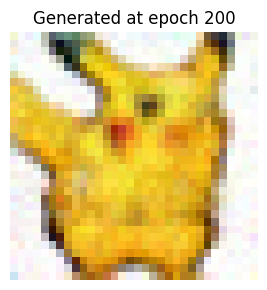

Group 5/10: 100%|██████████| 50/50 [00:05<00:00,  9.51it/s, loss=0.1305]



Epoch 250: Loss = 0.1305


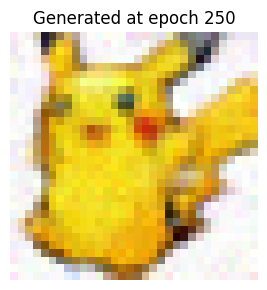

Group 6/10: 100%|██████████| 50/50 [00:05<00:00,  8.45it/s, loss=0.0899]



Epoch 300: Loss = 0.0899


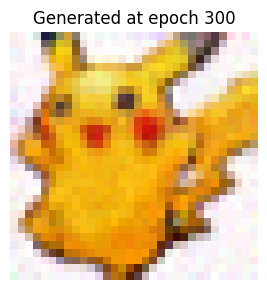

Group 7/10: 100%|██████████| 50/50 [00:06<00:00,  8.30it/s, loss=0.0970]



Epoch 350: Loss = 0.0970


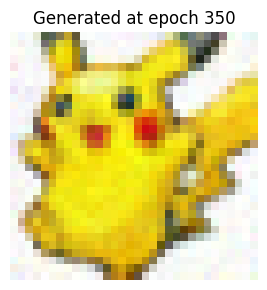

Group 8/10: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s, loss=0.1138]



Epoch 400: Loss = 0.1138


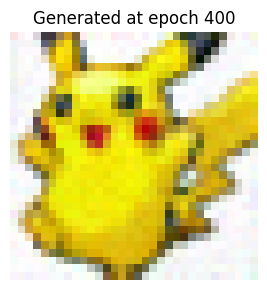

Group 9/10: 100%|██████████| 50/50 [00:05<00:00,  8.78it/s, loss=0.0671]



Epoch 450: Loss = 0.0671


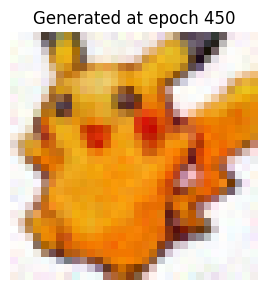

Group 10/10: 100%|██████████| 50/50 [00:05<00:00,  9.10it/s, loss=0.0307]



Epoch 500: Loss = 0.0307


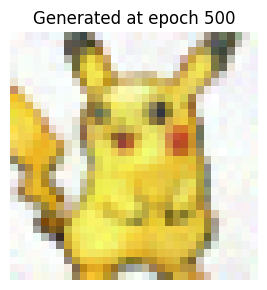


Training complete!
Generating samples from trained model...


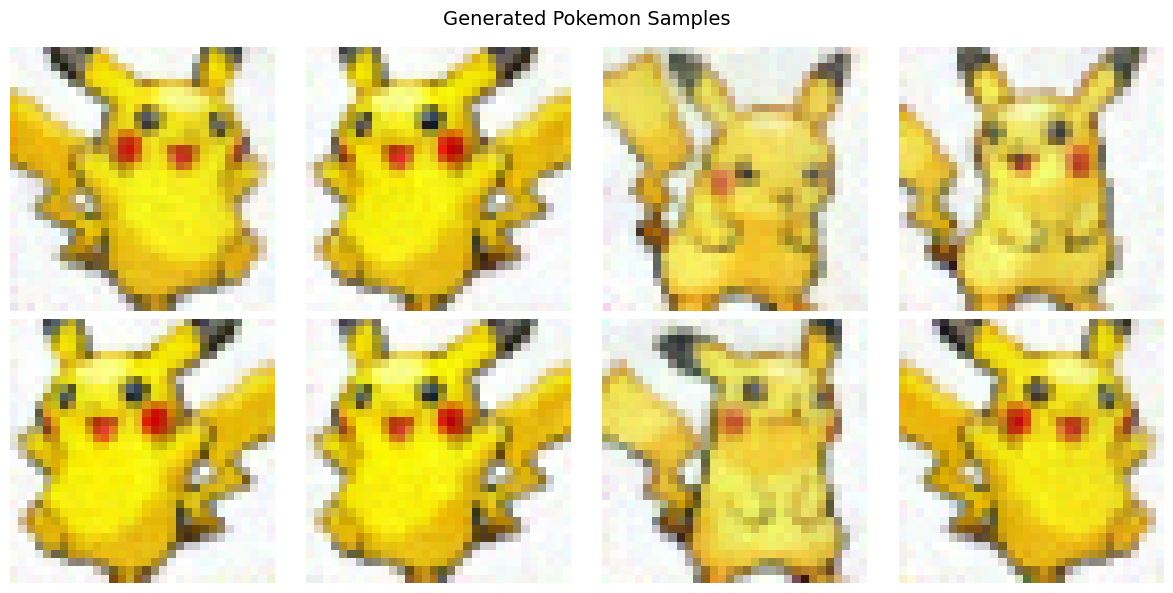

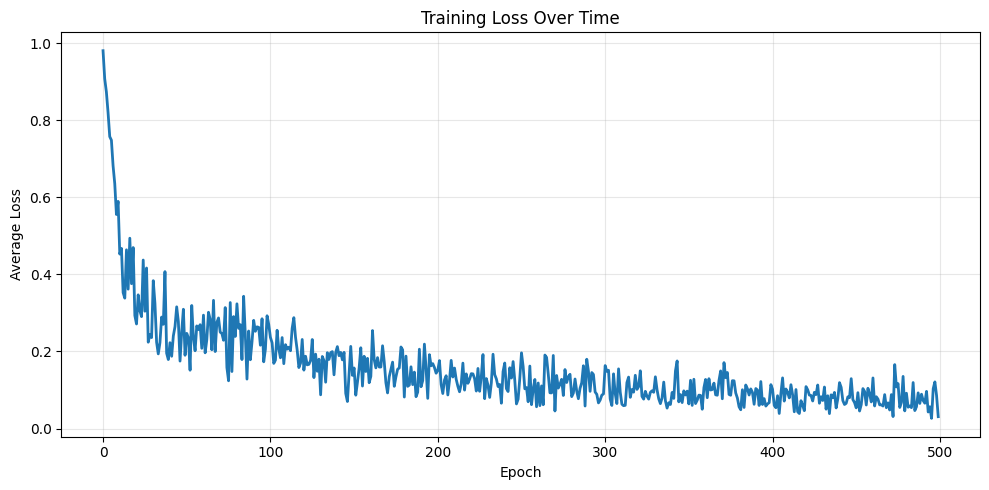

In [9]:
# Run this cell to train and visualize results

# starting with a fresh model every training run
model = SimpleUNet().to(device)

# Recommended default training hyperparameters, but can modify as needed
losses = train(model, dataloader, num_epochs=500, lr=1e-4, gen_freq=50)

# Generate a grid of examples
print("Generating samples from trained model...")
_, alphas = prepare_noise_schedule(device, timesteps=T)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax in axes.flat:
    sample = sample_image(model, alphas, device)
    show_image_tensor(sample, ax=ax)

plt.suptitle("Generated Pokemon Samples", fontsize=14)
plt.tight_layout()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()